<a href="https://colab.research.google.com/github/GurkiratSarna/CE888-Decision-Making-UoE/blob/master/Assignment_2/CE888_Assignment_2_Project_3_1900690.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt #plotting charts
import pandas as pd #helps importing datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [0]:
def create_DT_classifier(Data_in):
    #print('DT Classification function')
    #print(Data_in)
    train_set, test_set = train_test_split(Data_in, test_size = 0.3, random_state=42)

    Data_train_x=train_set.iloc[:,0:9]
    #Data_train_x.sort_index(inplace=True)
    #print(Data_train_x)

    Data_train_y=train_set.iloc[:,-1]
    #Data_train_y.sort_index(inplace=True)
    Data_train_y=Data_train_y.astype('int')
    #print(Data_train_y)

    Data_test_x=test_set.iloc[:,0:9]
    #Data_test_x.sort_index(inplace=True)
    #print(Data_test_x)

    Data_test_y=test_set.iloc[:,-1]
    #Data_test_y.sort_index(inplace=True)
    Data_test_y=Data_test_y.astype('int')
    #print(Data_test_y)

    classifier_DT = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
    classifier_DT.fit(Data_train_x, Data_train_y)
    Pred_test_y=classifier_DT.predict(Data_test_x)
    print(classification_report(Data_test_y,Pred_test_y))


    ########################
    #Plotting DT
    depth_range = list(range(1,40))
    accuracy_list = []
    for depth in depth_range:
        classifier_DT1 = DecisionTreeClassifier(criterion='gini',max_depth=depth,random_state=42)
        classifier_DT1.fit(Data_train_x, Data_train_y)
        score = classifier_DT1.score(Data_test_x, Data_test_y)
        accuracy_list.append(score)
    plt.plot(depth_range,accuracy_list)
    plt.show()
    print(max(accuracy_list))
    print(accuracy_list.index(max(accuracy_list)))
    #########################
    
    
    return classifier_DT

In [0]:
# This is a very simple implementation of the UCT Monte Carlo Tree Search algorithm in Python 2.7.
# The function UCT(rootstate, itermax, verbose = False) is towards the bottom of the code.
# It aims to have the clearest and simplest possible code, and for the sake of clarity, the code
# is orders of magnitude less efficient than it could be made, particularly by using a 
# state.GetRandomMove() or state.DoRandomRollout() function.
# 
# Example GameState classes for Nim, OXO and Othello are included to give some idea of how you
# can write your own GameState use UCT in your 2-player game. Change the game to be played in 
# the UCTPlayGame() function at the bottom of the code.
# 
# Written by Peter Cowling, Ed Powley, Daniel Whitehouse (University of York, UK) September 2012.
# 
# Licence is granted to freely use and distribute for any sensible/legal purpose so long as this comment
# remains in any distributed code.
# 

from math import *
import random
import pandas as pd #To convert the final dataset into a dataframe.

class OXOState:
    """ A state of the game, i.e. the game board.
        Squares in the board are in this arrangement
        012
        345
        678
        where 0 = empty, 1 = player 1 (X), 2 = player 2 (O)
    """
    def __init__(self):
        self.playerJustMoved = 2 # At the root pretend the player just moved is 2 whereas player 1 has the first move.
        self.board = [0,0,0,0,0,0,0,0,0] # 0 = empty, 1 = player 1, 2 = player 2. This is the initial board state - all positions are empty.
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = OXOState()
        st.playerJustMoved = self.playerJustMoved
        st.board = self.board[:]
        return st

    def DoMove(self, move):
        """ Update the state board by replacing 0 with the player playing the move at the position/move of the board.
            Must update playerJustMoved.
        """
        assert move >= 0 and move <= 8 and move == int(move) and self.board[move] == 0
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state. That is return all the positional values of the zroes in the state board.
        """
        return [i for i in range(9) if self.board[i] == 0]
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """
        #print("in getresult")
        for (x,y,z) in [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]:
            #Winning possibilities of the board
            #print("In for loop")
            if self.board[x] == self.board[y] == self.board[z]: # check if values in all the 3 positions is of the same player
                # check if the player that just moved is same as the value in the winning positions, if yes return 1 else 0 stating that the other player wins.
                #print("In first if")
                if self.board[x] == playerjm: 
                    #print("return 1.0")
                    return 1.0
                else:
                    #print("return 0.0")
                    return 0.0
        if self.GetMoves() == []:
          #print("return 0.5")
          return 0.5 # draw
        return False # Should not be possible to get here

    def __repr__(self): # This is how the return value is defined for this class.
        s= ""
        for i in range(9): 
            s += ".XO"[self.board[i]] # . for 0, X for 1 and O for 2 positional values
            if i % 3 == 2: s += "\n"
        return s


class Node:
    """ A node in the game tree. Note : wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        #parentNode stores all the parents from the rootnode until the current node for backpropogation, during which it deletes until it is None.
        self.parentNode = parent # "None" for the root node.
        self.childNodes = []
        self.wins = 0
        self.visits = 0 #The number of itermax passed
        self.untriedMoves = state.GetMoves() # future child nodes. The available positions to be played at any point of the game.
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        #print("In UCTSelectChild : ", self.wins,":",":",self.visits)
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1] #pick the highest
        #print("KEY : ", key)
        #print("S : ", s)
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node.
        """
        n = Node(move = m, parent = self, state = s)
        #print("In Adchild, n : ", n)
        self.untriedMoves.remove(m)
        #print("In Adchild, n : ", n)
        self.childNodes.append(n)
        #print("In Adchild, n : ",n.move, n.parentNode, n.childNodes, n.wins, n.visits, n.untriedMoves, n.playerJustMoved)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result

    def __repr__(self): # Added other variables to be retiurned to check the flow of the variable during testing small iterations.
        return "[M:" + str(self.move) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + " PJM:" + str(self.playerJustMoved) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s

def GetRandomMove(s,c_dt):
    #We will pick a random value between 0.0 and 1.0. Considering there is a normal distribution between these values, 
    #if we get a value between 0.0 and 0.9 then the decision tree classifier decides the next move on the given state otherwise a random integer is returned.
    rand_num=random.uniform(0.0, 1.0)
    print("In GetRandomMove, rand_num : ", rand_num)
    #print('type(s) : ', type(s))
    print('s.GetMoves() : ', s.GetMoves())
    #avail_moves=s.GetMoves()
    #print(c_dt)
    if rand_num <= 0.9:
        next_move=c_dt.predict([s.board])
        next_move=next_move[0]
        if next_move not in s.GetMoves():
            print('Next move not in get moves')
            #while next_move not in s.GetMoves():
            #    next_move=c_dt.predict([s.board])
            #    next_move=next_move[0]
            next_move=random.choice(s.GetMoves())
            #add the move taken at this state
            st_board=list(s.board)
            st_board.append(next_move)
            train_state.append(st_board)            
        print("next_move by DT : ", next_move)
    else:
        next_move=random.choice(s.GetMoves())
        print("next_move not by DT : ", next_move)
    #print('type(next_move) : ', type(next_move))
    return next_move
    
def UCT(firstrun, classifier_dt, rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""

    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            print("In Select")
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
            print("In Expand")
            m = random.choice(node.untriedMoves) # this m has to be picked by the DT train 90% times and 10% randomly.
            print("Random choice : ", m)
            state.DoMove(m)
            node = node.AddChild(m, state)  # add child and descend tree. This updates the parent node as well.
            #print("node : ", node.move, node.parentNode, node.childNodes, node.wins, node.visits, node.untriedMoves, node.playerJustMoved)

        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function.
        # This loop will play a game within the random move picked up before and then return the best move for one chance of the actual game being played.
        while state.GetMoves() != []: # while state is non-terminal
            if firstrun==1:
                print("Rollout : In First run")
                r=random.choice(state.GetMoves())
                #print(type(r))
            else:
                print("Rollout : Not in First run")
                #print(state.board)
                #print(type(state.board))
                r=GetRandomMove(state, classifier_dt)
            print("In Rollout. r : ", r, state.board)
            state.DoMove(r)
        
        #print("After Rollout state : ", state.playerJustMoved, state.board)
        #print("After Rollout node : ", node.move, node.parentNode, node.childNodes, node.wins, node.visits, node.untriedMoves, node.playerJustMoved)
        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            gr=state.GetResult(node.playerJustMoved)
            #print("In Backpropogate state.GetResult(node.playerJustMoved) : ", gr)
            node.Update(gr) # state is terminal. Update node with result from POV of node.playerJustMoved
            #print("node: ",node.move, node.parentNode, node.childNodes, node.wins, node.visits, node.untriedMoves, node.playerJustMoved )
            node = node.parentNode

    # Output some information about the tree - can be omitted
    #if verbose: print(rootnode.TreeToString(0))
    #else: print(rootnode.ChildrenToString())
    
    ret=sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move
    print("Return value of UCT : ", ret)
    return ret # return the move that was most visited as the best move.
                
def UCTPlayGame(firstrun, classifier_dt): #These simulations are MCTS
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    state = OXOState()

    tempdataset=[[0,0,0,0,0,0,0,0,0]] # LINE ADDED. A temporary datset which will accumulate all the stages of one game
    # A list of best moves for that particular game. This will always have length of tempdataset-1 because of the initial stage in the temporary dataset.
    bestmovelist=[] # LINE ADDED.
    while state.GetMoves() != []:
        #print(str(state)) # prints the board - Uncomment
        if state.playerJustMoved == 1:
            # Biased towards one player so that someone wins. 
            #1000:2000 -> No one wins; 1500:2000 -> No one wins; 10:1000 -> nearly 2.5% winning
            #10:1000 -> with 5000 iterations of UCTPlaygame -> 12.5% winning games
            m = UCT(firstrun, classifier_dt, rootstate=state, itermax=10, verbose=False)  # play with values for itermax and verbose = True.
            #print("In 10 itermax")
        else:
            m = UCT(firstrun, classifier_dt, rootstate=state, itermax=5, verbose=False) # itermax decides the total value of visits to one node in a given game.
            #print("In 5 itermax")
        #print("Best Move: " + str(m) + "\n") # Uncomment
        state.DoMove(m)
        
        bestmovelist.append(m) # LINE ADDED. 
        tempdataset.append(list(state.board))  #LINE ADDED.
        
        if state.GetResult(state.playerJustMoved) != False:
            #print(str(state)) # Uncomment
            break
    
    if state.GetResult(state.playerJustMoved) == 1.0:
        #print("Player " + str(state.playerJustMoved) + " wins!")
        winner=state.playerJustMoved
    elif state.GetResult(state.playerJustMoved) == 0.0:
        #print("Player " + str(3 - state.playerJustMoved) + " wins!")
        winner=state.playerJustMoved
    else: 
      #print("Nobody wins!")
      winner=0

    # This list will always have one element less compared to tempdataset because the last state of the game will never have any move associated to it.
    # Because we are combining the two lists so we want them of equal length hence the move of the last stage will be NaN, 
    # the last game state will be removed later from the final dataframe.
    bestmovelist.append('NaN')  # LINE ADDED.
    
    for i in range(len(tempdataset)): # LINE ADDED
      tempdataset[i].append(bestmovelist[i]) # LINE ADDED. Append the move taken at every stage.

    return tempdataset, winner # LINE ADDED.

def create_OXO_dataset(num_games, firstrun, classifier_dt):
    """ Play a single game to the end using UCT for both players. 
    """
    finaldataset=[] # LINE ADDED. A list os lists of the game stages. Each list is one game, representing the lists of stages returned.
    finaldataset1=[] # LINE ADDED. A list of all the stages of the games in the finaldataset. It is the output of converting a list of list into one list.
    
    p1win=0
    p2win=0
    Nowin=0
    winner=0
    for i in range(num_games): # Run the UCTPlayGame 2000 or 5000 times.
      returnds, winner =UCTPlayGame(firstrun, classifier_dt) # returnds stores the game temporarily.
      finaldataset.append(returnds) 
      #print("Winner : ", winner)
      if winner==1:
        p1win+=1
      elif winner==2:
        p2win+=1
      else:
        Nowin+=1
    #print(finaldataset)
    #Convert list of lists to one list
    for i in finaldataset:  
      for j in i:  
        finaldataset1.append(j) 
    #print(finaldataset1)
    #Name the columns of the finaldataset1 and convert it into a dataframe. # LINE ADDED
    datatbp=pd.DataFrame(finaldataset1, columns=['0th pos', '1st pos', '2nd pos', '3rd pos', '4th pos', '5th pos', '6th pos', '7th pos', '8th pos', 'Move'])
     
    #Remove the rows that have 'NaN' as these are the rows depicting the last stage of the game with no move.
    datatbp.drop(datatbp[datatbp.Move == 'NaN'].index, inplace=True)
    datatbp.reset_index(drop=True, inplace=True) #  Reset the row index of the data frame
    #print(datatbp)
    #print("Wins : \n Player1 : ", p1win, " Player2 : ", p2win, " Nobody wins : ", Nowin)
    
    return datatbp

Streaming output truncated to the last 5000 lines.
Rollout : In First run
In Rollout. r :  2 [2, 0, 0, 1, 0, 0, 1, 2, 0]
Rollout : In First run
In Rollout. r :  5 [2, 0, 1, 1, 0, 0, 1, 2, 0]
Rollout : In First run
In Rollout. r :  8 [2, 0, 1, 1, 0, 2, 1, 2, 0]
Rollout : In First run
In Rollout. r :  1 [2, 0, 1, 1, 0, 2, 1, 2, 1]
Rollout : In First run
In Rollout. r :  4 [2, 2, 1, 1, 0, 2, 1, 2, 1]
In Expand
Random choice :  2
Rollout : In First run
In Rollout. r :  5 [0, 0, 2, 1, 0, 0, 1, 2, 0]
Rollout : In First run
In Rollout. r :  1 [0, 0, 2, 1, 0, 1, 1, 2, 0]
Rollout : In First run
In Rollout. r :  0 [0, 2, 2, 1, 0, 1, 1, 2, 0]
Rollout : In First run
In Rollout. r :  8 [1, 2, 2, 1, 0, 1, 1, 2, 0]
Rollout : In First run
In Rollout. r :  4 [1, 2, 2, 1, 0, 1, 1, 2, 2]
In Expand
Random choice :  5
Rollout : In First run
In Rollout. r :  2 [0, 0, 0, 1, 0, 2, 1, 2, 0]
Rollout : In First run
In Rollout. r :  8 [0, 0, 1, 1, 0, 2, 1, 2, 0]
Rollout : In First run
In Rollout. r :  1 [0, 0, 1,

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


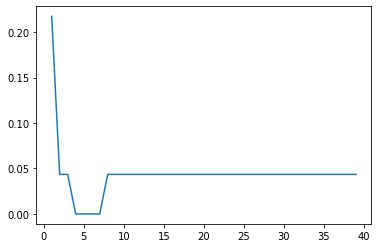

Streaming output truncated to the last 5000 lines.
In GetRandomMove, rand_num :  0.7937559297083729
s.GetMoves() :  [1, 3, 5, 6, 7, 8]
Next move not in get moves
next_move by DT :  5
In Rollout. r :  5 [2, 0, 1, 0, 1, 0, 0, 0, 0]
Rollout : Not in First run
In GetRandomMove, rand_num :  0.4405509698593232
s.GetMoves() :  [1, 3, 6, 7, 8]
Next move not in get moves
next_move by DT :  3
In Rollout. r :  3 [2, 0, 1, 0, 1, 2, 0, 0, 0]
Rollout : Not in First run
In GetRandomMove, rand_num :  0.9524467102134823
s.GetMoves() :  [1, 6, 7, 8]
next_move not by DT :  6
In Rollout. r :  6 [2, 0, 1, 1, 1, 2, 0, 0, 0]
Rollout : Not in First run
In GetRandomMove, rand_num :  0.8879497163342801
s.GetMoves() :  [1, 7, 8]
next_move by DT :  7
In Rollout. r :  7 [2, 0, 1, 1, 1, 2, 2, 0, 0]
Rollout : Not in First run
In GetRandomMove, rand_num :  0.6950733765744432
s.GetMoves() :  [1, 8]
Next move not in get moves
next_move by DT :  1
In Rollout. r :  1 [2, 0, 1, 1, 1, 2, 2, 1, 0]
Rollout : Not in First run

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


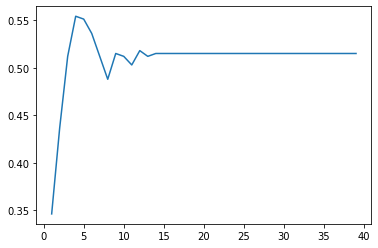

Streaming output truncated to the last 5000 lines.
Rollout : Not in First run
In GetRandomMove, rand_num :  0.8168706576985196
s.GetMoves() :  [3]
Next move not in get moves
next_move by DT :  3
In Rollout. r :  3 [2, 2, 1, 0, 1, 1, 2, 2, 1]
In Expand
Random choice :  8
Rollout : Not in First run
In GetRandomMove, rand_num :  0.4139553206066596
s.GetMoves() :  [0, 2, 3, 5, 6, 7]
next_move by DT :  3
In Rollout. r :  3 [0, 2, 0, 0, 1, 0, 0, 0, 1]
Rollout : Not in First run
In GetRandomMove, rand_num :  0.7380202921715356
s.GetMoves() :  [0, 2, 5, 6, 7]
next_move by DT :  0
In Rollout. r :  0 [0, 2, 0, 2, 1, 0, 0, 0, 1]
Rollout : Not in First run
In GetRandomMove, rand_num :  0.36549927130295967
s.GetMoves() :  [2, 5, 6, 7]
next_move by DT :  5
In Rollout. r :  5 [1, 2, 0, 2, 1, 0, 0, 0, 1]
Rollout : Not in First run
In GetRandomMove, rand_num :  0.9571635754344375
s.GetMoves() :  [2, 6, 7]
next_move not by DT :  2
In Rollout. r :  2 [1, 2, 0, 2, 1, 2, 0, 0, 1]
Rollout : Not in First run

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     0th pos  1st pos  2nd pos  3rd pos  ...  6th pos  7th pos  8th pos  Move
0          0        0        0        0  ...        0        0        0     7
1          0        0        0        0  ...        0        1        0     2
2          0        0        2        0  ...        0        1        0     4
3          0        0        2        0  ...        0        1        0     1
4          0        2        2        0  ...        0        1        0     8
..       ...      ...      ...      ...  ...      ...      ...      ...   ...
924        1        1        1        0  ...        0        2        2     3
925        1        1        1        2  ...        0        2        2     6
926        1        2        1        0  ...        1        2        2     3
927        1        2        1        1  ...        0        2        2     6
928        1        2        1        1  ...        0        2        2     6

[929 rows x 10 columns]
              precision    recall  f1-s

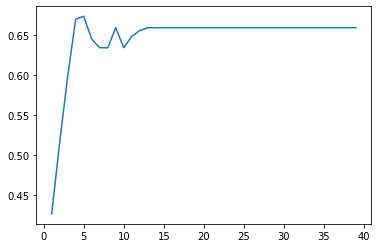

0.6738351254480287
4
After clearing in this iteration train_state :  []


In [45]:
if __name__ == "__main__":
   #Play 5000 games and create a dataset without decision tree execution.
   firstrun=1
   global train_state
   train_state=[]
   classifier=None
   print('train_state : \n ', train_state)
   for i in range(3):
       print('train_state start of iteration: \n ', train_state)
       data_tbp=create_OXO_dataset(10,firstrun, classifier)
       print('data_tbp : \n ', data_tbp)
       #print('type(data_tbp) : ',type(data_tbp))
       print('train_state : \n ',train_state)
       #print('type(train_state) : ', type(train_state))
       print('Length of data_tbp : ',len(data_tbp))
       comb_train_state=pd.DataFrame(train_state,columns=['0th pos', '1st pos', '2nd pos', '3rd pos', '4th pos', '5th pos', '6th pos', '7th pos', '8th pos', 'Move'])
       print('Length of data_tbp : ',len(comb_train_state))
       data_tbp=pd.concat([data_tbp,comb_train_state],ignore_index=True, axis=0)
       print('data_tbp1 : \n', data_tbp)
       #combine the data_tbp and train_state here and then create a classifier
       classifier=create_DT_classifier(data_tbp)
       firstrun=0
       train_state.clear()
       print('After clearing in this iteration train_state : ', train_state)

In [0]:
#Download the Dataset to be processed in Assignment 2
#2000*10= 20000; 20000-2000=18000 rows if nobody wins for all games.
from google.colab import files
datatbp.to_csv('CE888_DataToBeProcessed_1900690.csv')
files.download('CE888_DataToBeProcessed_1900690.csv')

# Assignment 2 Coding

In [0]:
'''!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials'''

In [0]:
'''auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)'''

In [0]:
'''file_id = r'C:\Users\DELL\OneDrive - University of Essex\CE888 - Decision Making\CE888_DataToBeProcessed_1900690_471Win.csv'
downloaded = drive.CreateFile({'id': file_id})
#downloaded = drive.CreateFile({'id':'C:\Users\DELL\OneDrive - University of Essex\CE888 - Decision Making\CE888_DataToBeProcessed_1900690_NobodyWins_2.csv'}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  

# Read file as panda dataframe
xyz = pd.read_csv('xyz.csv') '''

In [0]:
import os
print(os.getcwd())

/content


In [0]:
#Get data set from Drive
Data=pd.read_csv('CE888_DataToBeProcessed_1900690_6261Wins.csv')
Data

,Unnamed: 0,0th pos,1st pos,2nd pos,3rd pos,4th pos,5th pos,6th pos,7th pos,8th pos,Move
0,0,0,0,0,0,0,0,0,0,0,6
1,1,0,0,0,0,0,0,1,0,0,4
2,2,0,0,0,0,2,0,1,0,0,0
3,3,1,0,0,0,2,0,1,0,0,3
4,4,1,0,0,2,2,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
43735,43735,0,0,0,1,2,0,0,0,0,6
43736,43736,0,0,0,1,2,0,1,0,0,0
43737,43737,2,0,0,1,2,0,1,0,0,8
43738,43738,2,0,0,1,2,0,1,0,1,1


       0th pos  1st pos  2nd pos  3rd pos  ...  6th pos  7th pos  8th pos  Move
0            0        0        0        0  ...        0        0        0     6
1            0        0        0        0  ...        1        0        0     4
2            0        0        0        0  ...        1        0        0     0
3            1        0        0        0  ...        1        0        0     3
4            1        0        0        2  ...        1        0        0     1
...        ...      ...      ...      ...  ...      ...      ...      ...   ...
43735        0        0        0        1  ...        0        0        0     6
43736        0        0        0        1  ...        1        0        0     0
43737        2        0        0        1  ...        1        0        0     8
43738        2        0        0        1  ...        1        0        1     1
43739        2        2        0        1  ...        1        0        1     7

[43740 rows x 10 columns]
<class 'panda

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


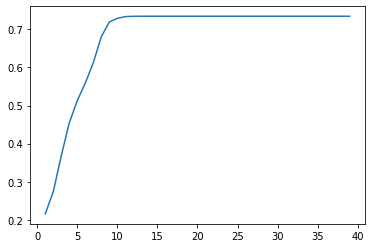

0.7341868617588783


In [0]:
c_dt=create_DT_classifier(Data)

In [0]:
test=[0,2,3]

In [0]:
test1=list(test)

In [20]:
id(test)

140019005050376

In [21]:
id(test1)

140019032690248

In [0]:
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],
                    'B': ['B0', 'B1', 'B2', 'B3'],
                    'C': ['C0', 'C1', 'C2', 'C3'],
                    'D': ['D0', 'D1', 'D2', 'D3']})
df2 = pd.DataFrame({'E': ['A0', 'A1', 'A2', 'A3'],
                    'F': ['B0', 'B1', 'B2', 'B3'],
                    'G': ['C0', 'C1', 'C2', 'C3'],
                    'H': ['D0', 'D1', 'D2', 'D3']})

In [40]:
df1

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3


In [41]:
df2

,E,F,G,H
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3


In [42]:
pd.concat([df1,df2],ignore_index=True)

,A,B,C,D,E,F,G,H
0,A0,B0,C0,D0,NaN,NaN,NaN,NaN
1,A1,B1,C1,D1,NaN,NaN,NaN,NaN
2,A2,B2,C2,D2,NaN,NaN,NaN,NaN
3,A3,B3,C3,D3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,A0,B0,C0,D0
5,NaN,NaN,NaN,NaN,A1,B1,C1,D1
6,NaN,NaN,NaN,NaN,A2,B2,C2,D2
7,NaN,NaN,NaN,NaN,A3,B3,C3,D3
